In [6]:
import geopandas as gpd
import pandas as pd
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from shapely.geometry import Point
from pyproj import Transformer
import pystac_client
from pystac_client.stac_api_io import StacApiIO
import planetary_computer
import leafmap
import leafmap.colormaps
from shapely import wkt

In [7]:
config_path = '/home/benchuser/code/config.yml'
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
        
version = config['dataset']['version']
# version = 'v0.40.2'
working_dir = Path(config['directory']['working'])
output_dir = Path(config['directory']['output'])
aoi_version = config['aoi']['version']

print(yaml.dump(config))

aoi:
  exclude_indices: null
  include_indices: null
  version: v0.30
chips:
  chip_size: 960
  sample_size: 960
dataset:
  version: v0.40.9
dem:
  collection: cop-dem-glo-30
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  resolution: 30
  year: 2021-01-02/2021-12-31
directory:
  output: /home/benchuser/final_data
  working: /home/benchuser/data
land_cover:
  collection: io-lulc-annual-v02
  dtype: int8
  fill_na: false
  na_value: 0
  native_crs: false
  resolution: 10
  sampling_factor: null
  year: 2023-01-02/2023-12-31
landsat:
  bands:
  - coastal
  - blue
  - green
  - red
  - nir08
  - swir16
  - swir22
  - qa_pixel
  cloud_band: qa_pixel
  cloud_cover: 100
  collection: landsat-c2-l2
  delta_days: 91
  dtype: float32
  fill_na: false
  na_value: -999
  native_crs: false
  platforms:
  - landsat-8
  - landsat-9
  resolution: 30
log_errors: true
sentinel_1:
  bands:
  - vv
  - vh
  collection: sentinel-1-rtc
  delta_days: 12
  dtype: float32
  fill_na: fa

In [8]:
metadata_filepath = Path(working_dir / version / 'chip_metadata.csv')

In [9]:
chip_df = pd.read_csv(metadata_filepath)

In [10]:
aoi_gdf = gpd.read_file(Path(working_dir) / version / 'aoi_metadata.geojson')
aoi_gdf['centroid'] = aoi_gdf.centroid
aoi_gdf.geometry = aoi_gdf['centroid']
print(Path(working_dir) / version / 'aoi_metadata.geojson')

/home/benchuser/data/v0.40.9/aoi_metadata.geojson


In [12]:
aoi_gdf.head()

status  \
0                                            success   
1                                            success   
2                                  s2 scenes missing   
3                                  s1 scenes missing   
4  Error reading Window(col_off=4096, row_off=409...   

                                            geometry  \
0  POLYGON ((21.64939 3.53375, 21.64939 3.45467, ...   
1  POLYGON ((18.96891 5.4779, 18.96891 5.44708, 1...   
2  POLYGON ((8.28178 7.2393, 8.28178 7.211, 8.304...   
3  POLYGON ((-2.53479 15.81157, -2.53479 15.42575...   
4  POLYGON ((38.53933 9.3094, 38.53933 8.72942, 3...   

                    centroid  
0   POINT (21.69238 3.49421)  
1   POINT (18.98749 5.46249)  
2    POINT (8.29336 7.22515)  
3  POINT (-2.33595 15.61866)  
4   POINT (38.80049 9.01941)

In [13]:
aoi_gdf['aoi_index'] = aoi_gdf.index

In [14]:
aoi_gdf['status'] = aoi_gdf['status'].map(lambda x: 'other error' if len(x) > 40 else x)

In [15]:
unique_statuses = list(aoi_gdf['status'].unique())
colors = leafmap.colormaps.get_palette('tab10', n_class=len(unique_statuses))
cmap = {status: f'#{color}' for status, color in zip(unique_statuses, colors)}
cmap['success'] = '#66FF00'
aoi_gdf['color'] = aoi_gdf['status'].map(lambda x: cmap[x])

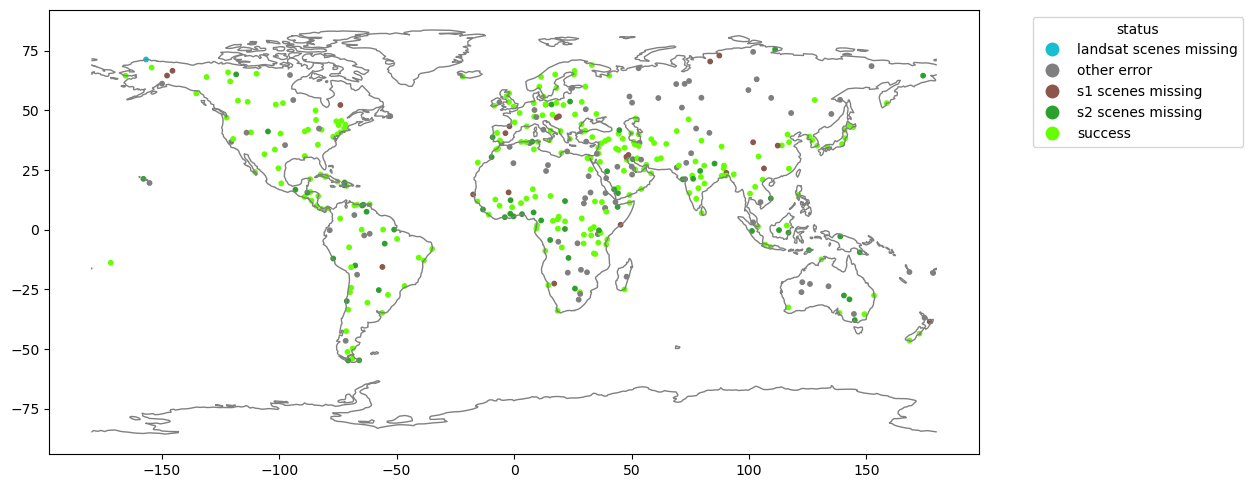

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)

aoi_gdf['status'] = aoi_gdf['status'].astype('category')
ordered_colors = [cmap[k] for k in aoi_gdf['status'].cat.categories]
cmap = ListedColormap(ordered_colors)

aoi_gdf.plot(
    'status', 
    cmap=cmap, 
    ax=ax, 
    markersize=10, 
    legend=True, 
    legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left', 'title': 'status'}
)
# Show the plot
plt.show()

In [17]:
aoi_gdf.explore('status', cmap=cmap, marker_kwds={'radius':4})

<Axes: xlabel='status'>

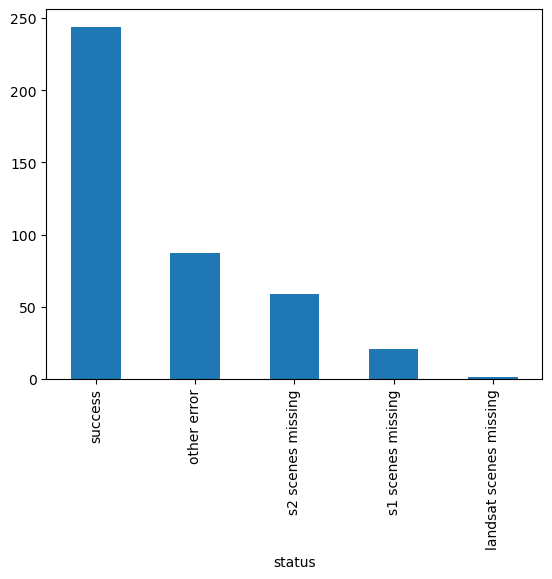

In [18]:
aoi_gdf['status'].value_counts().plot.bar()

In [19]:
len(aoi_gdf[aoi_gdf['status'] == 'success']) / len(aoi_gdf)

0.5922330097087378

In [20]:
pd.crosstab(chip_df['land_cover'], chip_df['status'], margins=True)

status      dem missing values  land_cover_11_limit  land_cover_1_limit  \
land_cover                                                                
1.0                      80567                    0               42914   
2.0                          3                    0                   0   
5.0                         26                    0                   0   
7.0                          3                    0                   0   
8.0                          9                    0                   0   
11.0                      1196               157072                   0   
All                      81804               157072               42914   

status      land_cover_2_limit  land_cover_5_limit  land_cover_7_limit  \
land_cover                                                               
1.0                          0                   0                   0   
2.0                      34890                   0                   0   
5.0                          0               25073                   0   
7.0                          0                   0                1640   
8.0                          0                   0                   0   
11.0                         0                   0                   0   
All                      34890               25073                1640   

status      land_cover_8_limit  landsat missing values  \
land_cover                                               
1.0                          0                  113418   
2.0                          0                  127309   
5.0                          0                   24275   
7.0                          0                   14871   
8.0                      35881                    3044   
11.0                         0                   53985   
All                      35881                  336902   

status      sentinel_1 missing values  sentinel_2 missing values  success  \
land_cover                                                                  
1.0                              1361                       1665     8301   
2.0                              1019                       2950    12809   
5.0                               614                       2256    17274   
7.0                               332                        625     6240   
8.0                                23                       1094     5859   
11.0                              993                       4613    27064   
All                              4342                      13203    77547   

status         All  
land_cover          
1.0         248226  
2.0         178980  
5.0          69518  
7.0          23711  
8.0          45910  
11.0        244923  
All         811268

In [21]:
chip_df.head()

chip_index  aoi_index sentinel_2_dates sentinel_1_dates landsat_dates  \
0           0          0               []               []            []   
1           1          0               []               []            []   
2           2          0               []               []            []   
3           3          0               []               []            []   
4           4          0               []               []            []   

   land_cover                                     chip_footprint   epsg  \
0         2.0  POLYGON ((21.224416643350825 4.516154752414078...  32634   
1         2.0  POLYGON ((21.24172443441945 4.516149188844357,...  32634   
2         2.0  POLYGON ((21.60518042270373 4.515936924188587,...  32634   
3         2.0  POLYGON ((21.613833894829913 4.515929649956859...  32634   
4         2.0  POLYGON ((21.709021108200727 4.515842818444417...  32634   

                   status  
0  landsat missing values  
1  landsat missing values  
2  landsat missing values  
3  landsat missing values  
4  landsat missing values

In [22]:
chip_df['chip_footprint_4326'] = gpd.GeoSeries(chip_df['chip_footprint'].dropna().map(wkt.loads), crs=4326)

In [23]:
chip_df = gpd.GeoDataFrame(chip_df, geometry = 'chip_footprint_4326', crs=4326)
chip_df['land cover and error'] = chip_df['land_cover'].astype(str) + '_' + chip_df['status']

In [24]:
aoi = 127

In [25]:
chip_df[chip_df['aoi_index'] == aoi].explore('land cover and error', tiles="http://mt0.google.com/vt/lyrs=s&hl=en&x={x}&y={y}&z={z}", attr="Google", marker_kwds=dict(radius=5))


In [26]:
land_cover_cmap = {
    "1": "#419bdf",  # Water
    "2": "#397d49",  # Trees
    "4": "#7a87c6",  # Flooded Vegetation
    "5": "#e49635",  # Crops
    "7": "#c4281b",  # Built Area
    "8": "#a59b8f",  # Bare Ground
    "9": "#a8ebff",  # Snow/Ice
    "10": "#616161",  # Clouds
    "11": "#e3e2c3"   # Rangeland
}

border_color_dict = {
    'success': '#66FF00',
    'landsat missing values': '#FFFFFF',
}

In [27]:
def get_color_from_status(land_cover: float):
    land_cover_string = str(land_cover).split('.')[0]
    hex_color = land_cover_cmap.get(land_cover_string, '#000000')
    return hex_color
def get_border_from_status(status: str):
    border_color = border_color_dict.get(status, '#000000')
    return border_color

In [28]:
callback = lambda feat: {
    "color": feat['properties']['border_color'],
    "weight": 2,
    "fillColor": feat['properties']['color'],
    "fillOpacity": 1
}
m = leafmap.Map()
aoi_chips = chip_df[chip_df['aoi_index'] == aoi]
aoi_chips['color']=aoi_chips['land_cover'].apply(lambda x: get_color_from_status(x))
aoi_chips['border_color']=aoi_chips['status'].apply(lambda x: get_border_from_status(x))
m.add_gdf(
    aoi_chips,
    style_callback=callback,
    layer_name=f"Chip Footprints (AOI {aoi})",
    zoom_to_layer=True,
)

In [29]:
stac_items = gpd.read_file(Path(working_dir) / version / f"{aoi}_stac_items.json")

Skipping field instruments: unsupported OGR type: 5
Skipping field s1:shape: unsupported OGR type: 1
Skipping field proj:bbox: unsupported OGR type: 3
Skipping field proj:shape: unsupported OGR type: 1
Skipping field proj:transform: unsupported OGR type: 3
Skipping field sar:polarizations: unsupported OGR type: 5


In [30]:
# initialize pystac client with retry policy
stac_api_io = StacApiIO()
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

In [31]:
supercell_ids = list(stac_items['supercell'].dropna().unique())
search = catalog.search(
    collections='io-lulc-annual-v02',
    datetime = '2023-01-02/2023-12-31',
    query = {
        'supercell' : {'in': supercell_ids}
    }
)
items = search.item_collection()

In [32]:
for item in items:
    url = item.assets['data'].href
    m.add_cog_layer(url, colormap = land_cover_cmap, zoom_to_layer=False)

In [33]:
m

Map(center=[59.916872592663125, 30.357406304671308], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Move a Sample of Chips

In [34]:
def get_first_n_chips(n, chip_df):
    success_chips = chip_df[chip_df['status'] == 'success']
    success

In [35]:
success_chips = chip_df[chip_df['status'] == 'success']

In [36]:
success_chips.head()

chip_index  aoi_index                                  sentinel_2_dates  \
318         318          0  ['20230218', '20230419', '20230713', '20231230']   
335         335          0  ['20230218', '20230419', '20230713', '20231230']   
336         336          0  ['20230218', '20230419', '20230713', '20231230']   
361         361          0  ['20230218', '20230419', '20230713', '20231230']   
381         381          0  ['20230218', '20230419', '20230713', '20231230']   

                                     sentinel_1_dates  \
318  ['20230218', '20230419', '20230712', '20231227']   
335  ['20230218', '20230419', '20230712', '20231227']   
336  ['20230218', '20230419', '20230712', '20231227']   
361  ['20230218', '20230419', '20230712', '20231227']   
381  ['20230218', '20230419', '20230712', '20231227']   

                                        landsat_dates  land_cover  \
318  ['20230217', '20230524', '20230921', '20231218']         2.0   
335  ['20230217', '20230524', '20230921', '20231218']         2.0   
336  ['20230217', '20230524', '20230921', '20231218']         2.0   
361  ['20230217', '20230524', '20230921', '20231218']         2.0   
381  ['20230217', '20230524', '20230921', '20231218']         1.0   

                                        chip_footprint   epsg   status  \
318  POLYGON ((21.829906017653045 4.281246489341873...  32634  success   
335  POLYGON ((21.84719712640063 4.272543531738797,...  32634  success   
336  POLYGON ((21.855847323944335 4.272533915944302...  32634  success   
361  POLYGON ((21.864487787408372 4.263840259591745...  32634  success   
381  POLYGON ((21.501164069742924 4.255478867754993...  32634  success   

                                   chip_footprint_4326 land cover and error  
318  POLYGON ((21.82991 4.28125, 21.82992 4.28993, ...          2.0_success  
335  POLYGON ((21.8472 4.27254, 21.84721 4.28123, 2...          2.0_success  
336  POLYGON ((21.85585 4.27253, 21.85586 4.28122, ...          2.0_success  
361  POLYGON ((21.86449 4.26384, 21.8645 4.27252, 2...          2.0_success  
381  POLYGON ((21.50116 4.25548, 21.50117 4.26416, ...          1.0_success

In [37]:
success_sample = success_chips.head(50)

In [38]:
chip_indices = [str(index).zfill(6) for index in success_sample.chip_index]

In [39]:
working_dir / version

PosixPath('/home/benchuser/data/v0.40.9')

In [40]:
def find_chip_files(indices: list[str], data_dir: Path) -> list[Path]:

    indices_set = set(indices)
    matching_files = []
    
    all_chip_files = data_dir.glob('*_*.*')

    for file_path in all_chip_files:
        if 'sentinel' in file_path.stem:
            chip_id = file_path.stem.split('_')[2]
        else:
            chip_id = file_path.stem.split('_')[1]
        if chip_id in indices_set:
            matching_files.append(file_path)
            
    return matching_files


In [41]:
sample_file_paths = find_chip_files(chip_indices, (working_dir / version))

In [43]:
dest_directory = working_dir / f'sample_chips_{version}'
dest_directory.mkdir(exist_ok=True)

In [45]:
dest_directory

PosixPath('/home/benchuser/data/sample_chips_v0.40.9')

In [46]:
import shutil
for sample_file_paths in sample_file_paths:
    shutil.copy(sample_file_paths, dest_directory)

In [49]:
success_sample.head()

chip_index  aoi_index                                  sentinel_2_dates  \
318         318          0  ['20230218', '20230419', '20230713', '20231230']   
335         335          0  ['20230218', '20230419', '20230713', '20231230']   
336         336          0  ['20230218', '20230419', '20230713', '20231230']   
361         361          0  ['20230218', '20230419', '20230713', '20231230']   
381         381          0  ['20230218', '20230419', '20230713', '20231230']   

                                     sentinel_1_dates  \
318  ['20230218', '20230419', '20230712', '20231227']   
335  ['20230218', '20230419', '20230712', '20231227']   
336  ['20230218', '20230419', '20230712', '20231227']   
361  ['20230218', '20230419', '20230712', '20231227']   
381  ['20230218', '20230419', '20230712', '20231227']   

                                        landsat_dates  land_cover  \
318  ['20230217', '20230524', '20230921', '20231218']         2.0   
335  ['20230217', '20230524', '20230921', '20231218']         2.0   
336  ['20230217', '20230524', '20230921', '20231218']         2.0   
361  ['20230217', '20230524', '20230921', '20231218']         2.0   
381  ['20230217', '20230524', '20230921', '20231218']         1.0   

                                        chip_footprint   epsg   status  \
318  POLYGON ((21.829906017653045 4.281246489341873...  32634  success   
335  POLYGON ((21.84719712640063 4.272543531738797,...  32634  success   
336  POLYGON ((21.855847323944335 4.272533915944302...  32634  success   
361  POLYGON ((21.864487787408372 4.263840259591745...  32634  success   
381  POLYGON ((21.501164069742924 4.255478867754993...  32634  success   

                                   chip_footprint_4326  
318  POLYGON ((21.82991 4.28125, 21.82992 4.28993, ...  
335  POLYGON ((21.8472 4.27254, 21.84721 4.28123, 2...  
336  POLYGON ((21.85585 4.27253, 21.85586 4.28122, ...  
361  POLYGON ((21.86449 4.26384, 21.8645 4.27252, 2...  
381  POLYGON ((21.50116 4.25548, 21.50117 4.26416, ...

In [156]:
success_sample.to_file(working_dir / f'sample_chips_{version}' / 'chip_metadata.json', driver='GeoJSON')

In [157]:
success_sample.to_csv(working_dir / f'sample_chips_{version}' / 'chip_metadata.csv')

In [158]:
import shutil
output_zip_file = working_dir / f'sample_chips_{version}'
shutil.make_archive(output_zip_file, 'zip', dest_directory)

'/home/benchuser/data/sample_chips_v0.40.7.zip'

In [159]:
shutil.rmtree(Path('/home/benchuser/code/data') / f'sample_chips_{version}')

In [160]:
shutil.copytree((working_dir / f'sample_chips_{version}'), Path('/home/benchuser/code/data') / f'sample_chips_{version}')

PosixPath('/home/benchuser/code/data/sample_chips_v0.40.7')